<div id="container" style="position:relative;">
<div style="float:left"><h1>  Capstone Projects NLP - William Nankap </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

# NLP ClassifyChat

An innovative text classification project based on natural language processing. It leverages conversations from the freeCodeCamp chat to provide an accurate and efficient solution for automatically categorizing messages and extracting relevant information from large volumes of textual data.

### **`Notebook 5: Word2Vec + Kmeans ¶`**

### **`Author: William Nankap`**

Work plan: https://docs.google.com/presentation/d/10xtITocBaQgZYtDw1yWe_FzQPgR7Je6EkNRv8IJVCPM/edit?usp=sharing


-----

# Table of Contents

- ### Introduction
- ### 1. Word2Vec
    - ### PCA
- ### 3. Data Modeling Kmeans
    - ### First launch
    - ### Hyperparameter optimization
- ### Conclusion

-----

# Introduction

In this notebook, we will explore the powerful combination of Word2Vec, K-means for text analysis. These techniques allow us to extract meaningful insights and discover patterns in text data.

Word2Vec is a popular algorithm used for word embedding, which represents words as dense vector representations. It captures the semantic relationships between words by mapping them into a continuous vector space. We will use Word2Vec to generate word embeddings that can capture the contextual information and semantic similarities of words in our text corpus.

In [39]:
# We import all the librairies need for exploration, visualization and modeling

import pandas as pd
import numpy as np

#Preprocessing & Tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA

import string
import re

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

from scipy import stats
from statsmodels.stats import multicomp
from scipy.stats import pearsonr
import statsmodels.api as sm

from wordcloud import WordCloud
import time


-----
# 1. Word2Vec

Word2Vec is a popular algorithm in the field of natural language processing (NLP) that is used for word embedding. Word embedding refers to the process of representing words as continuous vector representations in a high-dimensional space. This representation captures the semantic relationships and contextual information of words, enabling machines to better understand and work with textual data.

The main idea behind Word2Vec is to learn word embeddings by training a neural network on a large corpus of text. The neural network is trained to predict the context of a target word within a given window of surrounding words. Through this process, Word2Vec learns to encode words that have similar contexts into similar vector representations.

In [2]:
#Load data
preprocess_clean_freecodecamp_casual = pd.read_csv('preprocess_clean_freecodecamp_casual.csv')

In [3]:
#Checking null value
cs = preprocess_clean_freecodecamp_casual['clean_text'].isna().sum()

print(f'Our dataset contain {cs} null value in our clean_text column.')

Our dataset contain 420407 null value in our clean_text column.


In [4]:
#Cleaning null value
preprocess_clean_freecodecamp_casual = preprocess_clean_freecodecamp_casual.dropna()

These null values are probably due to the fact that there were empty rows in our dataset after the pre-processing process. All we have to do is delete them and move on.

## Vectorization 

As we have over 5 million data records, which is too much for our machine's capacity, we'll use a reduced set of our dataset for our work. Our sample will be around `4% of our dataset`.

### Sample

In [5]:
#Our sample
X_train = preprocess_clean_freecodecamp_casual['clean_text'].sample(frac=0.04, random_state=42)
print(f'Our sample contain {X_train.shape[0]} rows.')

Our sample contain 183413 rows.


# How our words are distributed in this sample?

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/

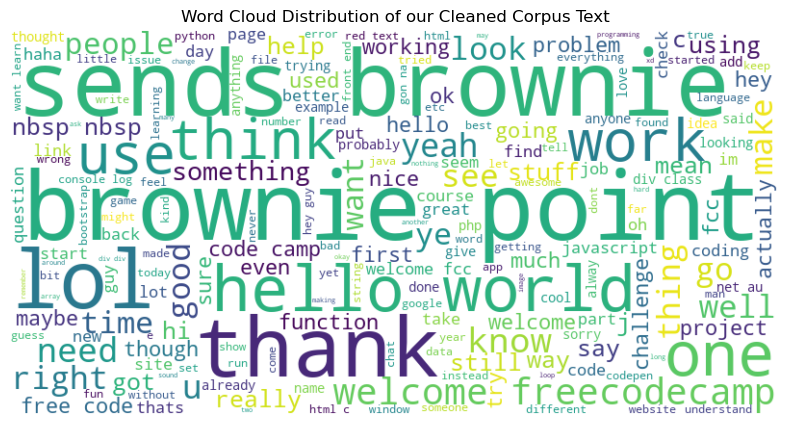

In [6]:
# Combine all the text data into a single string
combined_text = ' '.join(X_train)

# Create the Word Cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the Word Cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud Distribution of our Cleaned Corpus Text')
plt.axis('off')
plt.show()

This visual allows us to see the most frequent words in our dataset before vectorization.

We have a word that occurs 2 times, like `brownie`, and some important words like `point, freecodecamp, code, hello, world...`

When we look online, some comibination have a signification like:
- `brownie point:` This refer some gift exchange by user
- `hello world:` This refer to a common message you can see when you built you first code

We will go throw the vectorization to have more detail and try to see some pattern.

### Word2vec

In [7]:
# Tokenization
token_x = [word_tokenize(sentence) for sentence in X_train.to_list()]
token_x

[['paste',
  'screenshot',
  'wan',
  'na',
  'edit',
  'paste',
  'paint',
  'save',
  'drag',
  'drop'],
 ['help', 'format'],
 ['holy', 'moly'],
 ['great',
  'programmer',
  'knowing',
  'particular',
  'language',
  'knowing',
  'conceptualize',
  'problem',
  'solution'],
 ['need', 'ask'],
 ['welcome'],
 ['simpler', 'fix', 'would', 'love', 'know', 'wrong'],
 ['mean', 'within', 'browser', 'code', 'challenge', 'freecodecamp'],
 ['thanks', 'good', 'know'],
 ['imagined', 'kitchen', 'pomodoro', 'clock'],
 ['thank'],
 ['hello', 'azd', 'welcome', 'free', 'code', 'camp', 'community'],
 ['ask', 'come', 'lunch', 'place'],
 ['yeah', 'suck', 'goat', 'ba'],
 ['yes'],
 ['say'],
 ['fcc', 'give', 'everybody', 'samsung', 'galaxy', 'note'],
 ['rock',
  'started',
  'code',
  'camp',
  'today',
  'found',
  'link',
  'codecademy',
  'still',
  'answer',
  'saved',
  'year',
  'ago',
  'hope',
  'reentering',
  'old',
  'answer',
  'whole',
  'time'],
 ['ever', 'since', 'joined', 'kevin', 'guy', 'kind

In [8]:
#Our algortihm Word2Vec application
word2ve = w2v(
    token_x,
    min_count=3,  
    sg = 1,       
    window=7      
)

In [16]:
#Some word
selected_words = ['welcome', 'freecodecamp', 'work', 'time', 'yeah', 'issue', 'brownie']

#Overview on the similarity for some word (You can change the word if you want)
word2ve.wv.most_similar('brownie')

[('point', 0.797944188117981),
 ('cerebr', 0.7586414813995361),
 ('rphares', 0.7398169040679932),
 ('abhisekp', 0.7395715713500977),
 ('sends', 0.7386550307273865),
 ('abhinav', 0.7311843037605286),
 ('anthonygallina', 0.7283743023872375),
 ('thinktank', 0.7253749966621399),
 ('jbmartinez', 0.7146516442298889),
 ('mstellaluna', 0.7145199775695801)]

In [23]:
# Word embedding from our Word2Vec
def sentence_embedding(sentence):
    '''
    Generate the sentence embedding by averaging the word embeddings of the words in the sentence.

    Parameters:
    sentence (str): The input sentence.
    word2vec_model: The trained Word2Vec model.

    Returns:
    numpy.ndarray: The sentence embedding vector.

    '''
    
    vectors = [np.zeros(100,)]
    
    for word in word_tokenize(sentence):
        if word in word2ve.wv:
            vectors.append(word2ve.wv[word])
            
    return np.mean(vectors, axis=0)

In [24]:
#Applying the embedding function
X_train_sentence2vec = X_train.apply(sentence_embedding)

print(f'Our shape is {np.stack(X_train_sentence2vec.tolist()).shape}')

Our shape is (183413, 100)


PCA is a dimensionality reduction technique that transforms a set of variables (in this case, sentence embeddings) into a new lower-dimensional space, while preserving as much information as possible. In our case, we want to reduce the sentence embeddings to two dimensions so that they can be visualized more easily in a map.

[]

<Figure size 640x480 with 0 Axes>

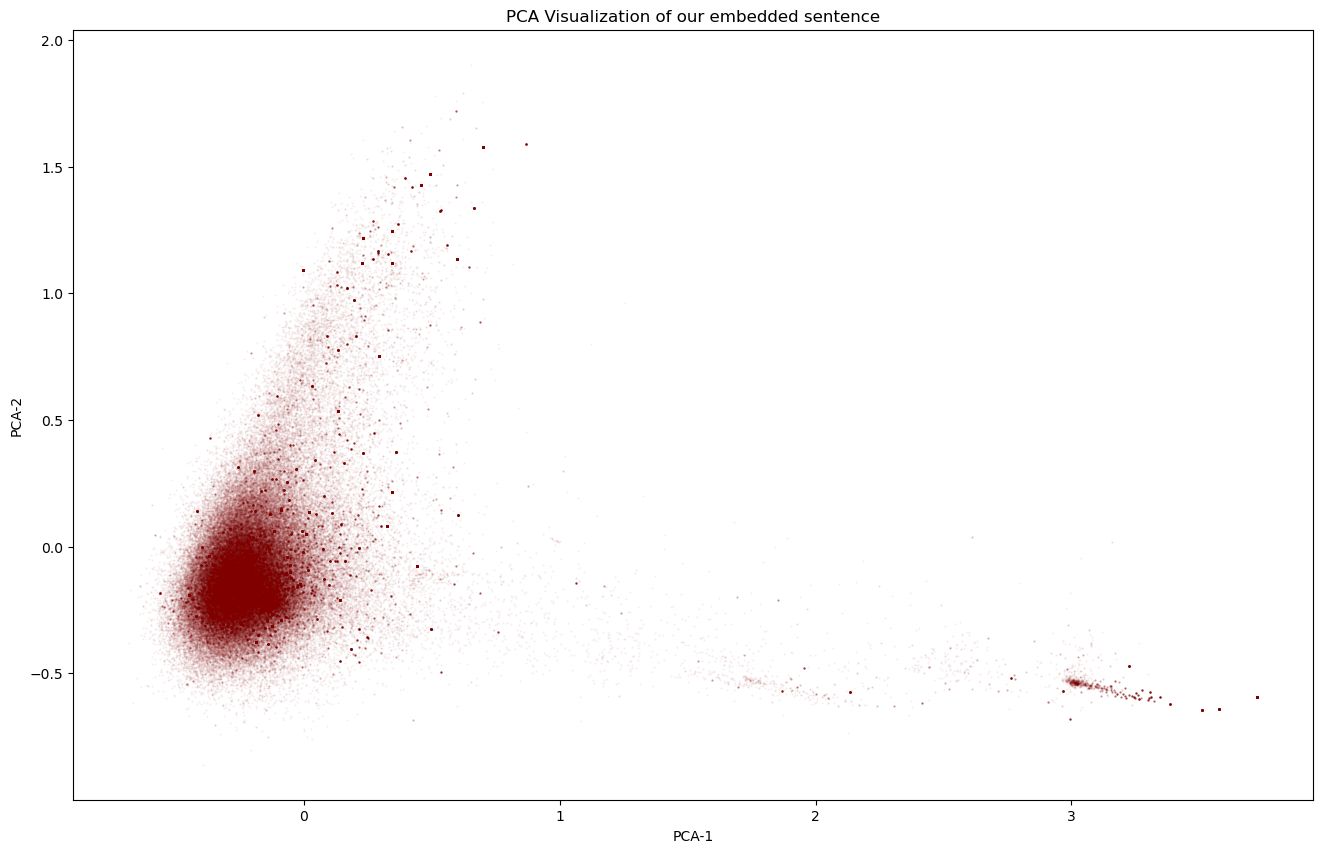

In [31]:
#Initiate PCA
pca = PCA(n_components=2, random_state=42)

#Fit transform PCA
pca_mdl = pca.fit_transform(np.stack(X_train_sentence2vec.tolist()))

# Create a DataFrame for the PCA results
emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
    )
)

plt.clf()
fig = plt.figure(figsize=(16,10))

# Scatter plot of the PCA results
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.05
)

# Set labels and title for the plot
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization of our embedded sentence')
plt.plot()

In this visual, I notice the presence of 3 groups of words. 1 much more concentrated than the other 2, which tend to disperse.

In [32]:
#Create dataframe with Word2vec vector
emb_df = (
    pd.DataFrame(
        [word2ve.wv.get_vector(str(n)) for n in word2ve.wv.key_to_index],
        index = word2ve.wv.key_to_index
    )
)
print(emb_df.shape)
emb_df.head()

(13603, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
code,0.309574,0.270626,-0.047381,0.328364,-0.591852,-0.341987,0.862186,0.615181,-0.497725,-0.415340,...,0.631486,0.006098,0.093554,0.253348,0.488788,-0.049592,-0.132340,-0.626854,-0.230029,0.115945
hello,-0.273712,0.291333,0.135589,-0.098999,0.069817,-0.585059,0.249230,0.648330,-0.080953,0.174343,...,0.457295,0.428422,0.156295,-0.313611,0.171810,0.389501,0.150575,-0.591094,-0.211632,-0.224534
like,-0.333361,0.146111,-0.041614,0.309038,0.083611,-0.231552,0.333910,0.011752,-0.181893,-0.144969,...,0.254189,0.425843,0.388191,0.051678,0.630841,-0.032988,0.116165,-0.114257,0.594436,-0.541037
welcome,-0.961492,0.879400,-0.189693,0.105665,0.468505,-1.042589,0.164983,1.070663,-0.377878,0.037599,...,0.077054,0.303508,0.296224,0.175715,0.486756,0.224230,0.077025,-0.901128,0.088045,-0.913761
point,-1.162502,0.617865,0.007959,0.194976,0.413433,0.386486,0.345668,0.460325,-0.491269,-0.322029,...,0.655621,1.103487,0.230005,0.156133,0.793006,-0.196496,0.151527,-0.114031,0.380402,-0.731972


[]

<Figure size 640x480 with 0 Axes>

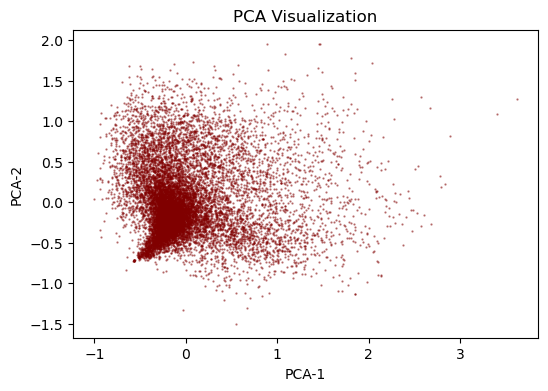

In [33]:
#Initiate PCA
pca = PCA(n_components=2, random_state=42)

#Fit transform PCA
pca_mdl = pca.fit_transform(emb_df)

# Create a DataFrame for the PCA results
emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

plt.clf()
fig = plt.figure(figsize=(6,4))

# Scatter plot of the PCA results
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)

# Set labels and title for the plot
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

Strong concentration to the left of our text corpus, a large similarity group in our data.


# 2. Kmeans

K-means clustering is a popular unsupervised machine learning algorithm used for partitioning data into distinct groups or clusters. It is an iterative algorithm that aims to find the optimal centroids of the clusters by minimizing the within-cluster variance.

In K-means, the number of clusters, denoted as K, is specified in advance. The algorithm starts by randomly selecting K points from the dataset as initial centroids. Then, it assigns each data point to the nearest centroid based on their distance, typically using Euclidean distance. After the assignment, the centroids are recalculated as the mean of the data points within each cluster. This process is repeated iteratively until convergence, where the centroids no longer change significantly or a specified number of iterations is reached.

The resulting clusters represent groups of similar data points, where the similarity is measured by their proximity to the centroids. K-means is widely used for various applications, such as customer segmentation, image compression, anomaly detection, and document clustering.

In this notebook, we will explore the use of K-means clustering as a technique to discover meaningful patterns or structure in our dataset. We will apply the K-means algorithm to our preprocessed data and analyze the resulting clusters to gain insights and make data-driven decisions.

## First, we will try to determine the best parameters for our model.

### Cluster number

In [41]:
#Scaling the data
X1 = np.stack(X_train_sentence2vec.tolist())

ss = StandardScaler()

X1 = ss.fit_transform(X1)

In [42]:
# Look over a range of K values
k_range = np.arange(1, 20)

# Instantiate an empty list of inertias
inertia_list = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(X1)
    
    # Get inertia and add to list
    inertia_list.append(k_means_model.inertia_)

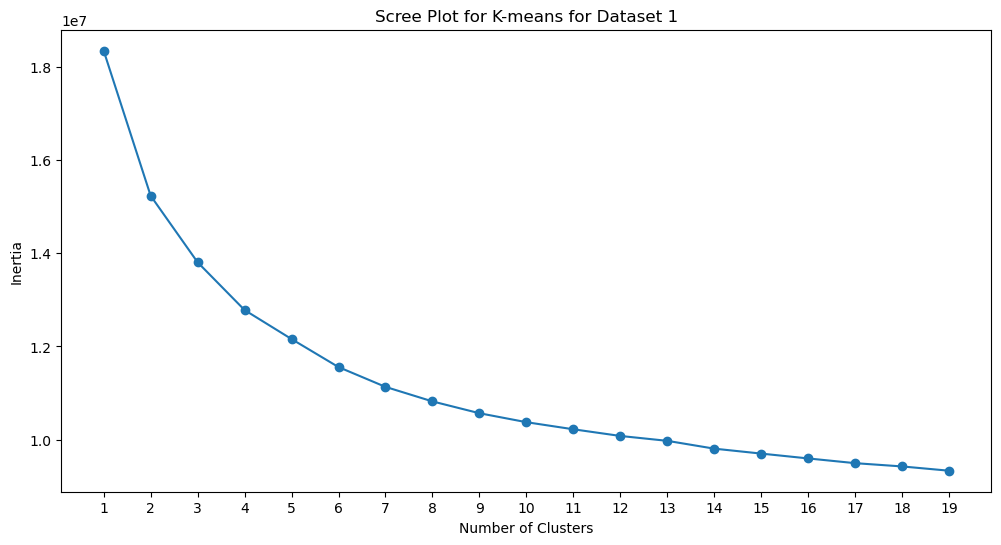

In [43]:
# Visualize our K number of cluster
plt.figure(figsize=(12,6))
plt.plot(k_range, inertia_list, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot for K-means for Dataset 1')
plt.xticks(k_range)
plt.show();

**It appears that the elbow point might be around 5 or 6 clusters.**

Let's look the distribution of the silhouette score.

In [ ]:
# Look over a range of K values
k_range = np.arange(2, 20)

# Instantiate an empty list of silhouette scores
silhouette_scores = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(X1)
    
    # Get cluster labels and calculate silhouette score
    cluster_labels = k_means_model.predict(X1)
    silhouette = silhouette_score(X1, cluster_labels)
    
    # Append to list
    silhouette_scores.append(silhouette)

In [ ]:
# plot the silhouette 
plt.figure()
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')
plt.title('Scree Plot for K-means for Old Faithful')
plt.xticks(k_range)
plt.show();

In [45]:
#Our lda model function
def model_kmeans(n_clusters=6, algorithm="elkan"):
    """
    Apply K-means clustering to the given data.

    Parameters:
    - n_components (int): Number of clusters to form.
    - max_iter (int): Maximum number of iterations for the algorithm to converge.
    - learning_method (str): The learning method to use. Possible values are "online" or "batch".

    Returns:
    - cluster_labels (array-like): Labels indicating the cluster membership for each data point.
    """
    
    # Initialize
    kmeans = KMeans(n_clusters=n_clusters, algorithm=algorithm)

    # Fit
    kmeans.fit(X1)

    # Predict
    cluster_labels = kmeans.predict(X1)
    
    print(f'The fit score (inertia) is: {kmeans.inertia_}')
    
    plt.figure(figsize=(16,10))
    plt.scatter(X1[:,0], 
                X1[:,99],
                c=cluster_labels, alpha=0.5)
    plt.show()
    
    return cluster_labels

The fit score (inertia) is: 12158373.37522094


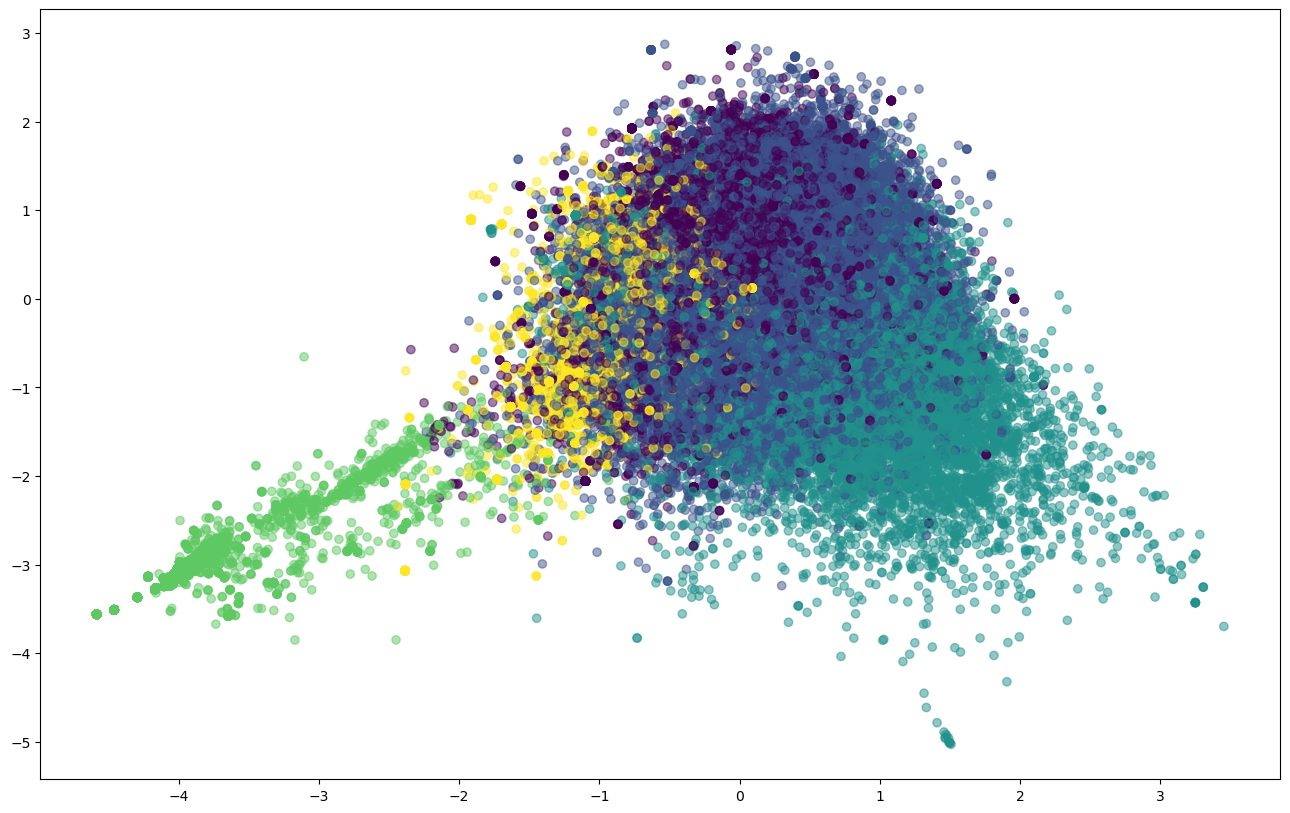

In [48]:
cl = model_kmeans(n_clusters=5, algorithm='elkan' )

-----
# Conclusion

In conclusion, in this Word2Vec notebook, we explored the use of the Word2Vec model to generate meaningful word embeddings from a text corpus. We trained our Word2Vec model on our specific dataset and extracted rich vector representations for each word.

With Word2Vec, we can in fact verify and confirm similarities between the words we've found by applying LDA (Latent Dirichlet Allocation) on CountVectorization or Tf-Idf.

Next, we used the K-means clustering algorithm to organize the word embeddings into clusters, enabling us to detect semantic similarities and groupings between words. This approach gave us an interesting perspective on the structure and relationships of words in our dataset.

We will save the model, to use that in TensorFlow and get some important visualization.

`tensorboard --logdir [model file name]`

In [49]:
word2ve.save('Word2Vec.model')

------

# Next Step
- ### Tensorflow & BERT